# PULSAR 52

In [1]:
 
import tensorflow as tf
import numpy
import scipy.io
import time
import glob


# PREPARO FUNZIONI

#TODO STUDIARE FATTIBILITÀ DI USARE TUTTO A 32BYTES

# calcola la correzione doppler per ogni punto del cielo
def doppcorr(i):
	quadratoNP = quadrato[i]
	indicesOpt = indices-1
	inizi = indicesOpt[:-1]
	fini = indicesOpt[1:]

	velocitas = numpy.zeros((3,frequenze.size))
	for i in numpy.arange(0,nTempi-1):
		velocitas[:,inizi[i]:fini[i]+1] = veloc[:,i:i+1]

	velPerPosIndex = numpy.dot(quadratoNP,velocitas)
	divisoreIndex = 1+velPerPosIndex
	freqCorr = frequenze / divisoreIndex
	##print(freqCorr)

	#mi ricavo l'header per le frequenze
	freqMin = numpy.amin(freqCorr)
	#freqMax = tf.reduce_max(freqCorr)
	freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato

	freqFinal = freqCorr-freqIniz
	freqFinal = (freqFinal/stepFreqRaffinato)-round(enhancement/2+0.001)

	#freqs = tf.concat([[freqIniz], freqCorr], 0)

	return freqIniz, freqCorr, freqFinal#, nstepFrequenze

def noncorr():
	freqMin = numpy.amin(frequenze)
	freqIniz = freqMin - stepFreq/2 -stepFreqRaffinato
	freqNonCor = (frequenze -freqIniz)/stepFreqRaffinato-round(enhancement/2+0.001)
	freqNonCor = tf.constant(freqNonCor, dtype = tf.float64)
	return freqNonCor


# calcola la hough per ogni punto del cielo (per ogni spindown)
def inDaHough(i, freqHM):
	def houghizza(stepIesimo):
		sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
		#sdTimed = tf.cast(sdTimed, dtype=tf.float32)

		appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
		appoggio = tf.cast(appoggio, dtype=tf.int32)

		#pesi32 = tf.cast(pesiHM, dtype = tf.float32)

		valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
		valorisx = tf.cast(valorisx, dtype=tf.float32)
		return valorisx

	houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

	def sliceInt():
		#faccio integrazione finale (vecchia versione senza conv)
		semiLarghezza = tf.round(enhancement/2+0.001)
		semiLarghezza = tf.cast(semiLarghezza, tf.int64)
		houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
		houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
		return houghInt

	hough = sliceInt()
	houghinal = tf.cumsum(hough, axis = 1)

	return houghinal


#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sessione = tf.Session(config=config)

#sessione = tf.Session()

# CARICO DATI

tFft = 8192
#tFft = 4096
tObs = 9 #mesi
tObs = tObs*30*24*60*60
cands = 100
primaFreq = 52

percorsoQuad = ("/home/protoss/Documenti/TESI/wn100bkp/quadHWI%d.mat" % primaFreq)
percorsoPatch = ("/home/protoss/Documenti/TESI/wn100bkp/quadHWI%dEcl.mat" % primaFreq)

#carico file per dopp corr
quadrato = scipy.io.loadmat(percorsoQuad)['quad'].astype(numpy.float64)
nPunti = quadrato.shape[0]
patch = scipy.io.loadmat(percorsoPatch)['quadratoEclNew'].astype(numpy.float64)

percorsoFile = ('/home/protoss/Documenti/TESI/wn100bkp/data/dati9mesi%dHWI.mat' % primaFreq)
#percorsoFile = 'dati/L/in_O2LL_01_0052_.mat'

#nPunti = 10
#nFiles = 2

allCands = numpy.zeros((1,nPunti,cands*2,9))

struttura = scipy.io.loadmat(percorsoFile)['job_pack_0']
tempi = struttura['peaks'][0,0][0]#.astype(numpy.float32)
primotempo = numpy.amin(tempi)
ultimotempo=numpy.amax(tempi)
frequenze = struttura['peaks'][0,0][1]#.astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1)#.astype(numpy.float32)

#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000
#securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement

#tempi
#epoca definita come mediana di tempi di tutto il run #WARNING da ridefinire con durata dati che prendo
epoca = (57722+57990)/2

#spindowns
spindownMin = -1e-9
spindownMax = 1e-10

#spindownMin = -2e-9
#spindownMax = 1e-9


stepSpindown = stepFreq/tObs
print(stepSpindown)
nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int64)
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

#per doppler corr
veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float64)
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
indices = struttura['basic_info'][0,0]['index'][0,0][0]



#mettere un for
#start = time.time()
#for punto in numpy.arange(0,nPunti):

sessione = tf.Session()
freqInCorr,freqCorr, freqPerHough = doppcorr(0)


nstepsFreq = numpy.ceil(securbelt+(numpy.amax(freqCorr)-numpy.amin(freqCorr) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato)
##print(nstepsFreq)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

	#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi,dtype=tf.float64)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float64)

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float64)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int64)

#freqTF = noncorr()

freqTF = tf.constant(freqPerHough, dtype = tf.float64)
houghmap = inDaHough(0,freqTF)
hough = sessione.run(houghmap)


minDistance = enhancement*4
primaFreq = freqInCorr-(securbelt/2)*stepFreqRaffinato

#freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
#freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]
freqIniziale = numpy.amin(frequenze)
freqFinale = numpy.amax(frequenze)
#QUI ANALOGO FUNZIONE CUT GD2
#%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
#%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]

indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

imageCand = hough[:,indexIniziale:indexFinale].astype(numpy.int64)


#allCands[ifile,punto] = manchurian_candidates(cands, freqInCorr, hough, patch[punto])

#tf.reset_default_graph()
#sessione.close()

	#numCands = numpy.
#stop = time.time()


#numAllCands = numpy.int64(allCands.size/9)
#allCands = allCands.reshape(numAllCands,9)
#nonzeri = numpy.nonzero(allCands[:,0])
#finallCands = allCands[nonzeri]
#finallCands = numpy.transpose(finallCands)



#percorsoOut = ('candHWI%d.mat' % primaFreq)
#percorsoOut = 'provacand'



5.2327808856310015e-12


In [3]:
t0 = 52944
epocaClean = (57722+57990)/2
deltaGiorni = epocaClean-t0
deltat = ((deltaGiorni)*24*3600)

f0 = 52.80832436
df0 = -4.03e-18
freqvera = df0*deltat+f0
freqvera

52.80832435828968

In [9]:
import numpy
#percorsoOut = 'HOUGH052LLHWI.npy'
percorsoOut = '/home/protoss/Documenti/TESI/wn100bkp/HOUGH052HWI.npy'
numpy.save(percorsoOut, imageCand)


In [18]:
import numpy
spindownMin = -1e-9
spindownMax = 1e-10

primaRiga = 0
ultimaRiga = nstepSpindown

indYtick = numpy.float32([0,2,4,6,8,10,12])
rigaScelta = indYtick + 185.0
sdScelto = (spindownMax-spindownMin)/(ultimaRiga-primaRiga)*(rigaScelta-primaRiga)+spindownMin
print(sdScelto)

valYtick = sdScelto
valYtick = valYtick - numpy.amin(numpy.absolute(valYtick))
print(valYtick)
print('----------------------')
valYtick = [ -3,  -2,  -1,   0,
   1,   2,   3]
#binSDScelti = (ultimaRiga-primaRiga)/(spindownMax-spindownMin)*(sdScelti-spindownMin)+primaRiga


indtoSD = 1

freqMin = numpy.amin(freqCorr)
freqMax = numpy.amax(freqCorr)
print(freqMin,freqMax)
primoIndice = 0
ultimoIndice = imageCand.shape[1]
print(ultimoIndice)

colonScelta = numpy.float32([66800,67330])
freqScelta = (freqMax-freqMin)/(ultimoIndice-primoIndice)*(colonScelta-primoIndice)+freqMin
print(freqScelta)
valXtick = [52.805,52.806,52.807,52.808,52.809,52.810,52.811,52.812]



freqScelta = valXtick
binFreqScelta  = (ultimoIndice-primoIndice)/(freqMax-freqMin)*(freqScelta-freqMin)+primoIndice
print(binFreqScelta)
indXtick = numpy.round(binFreqScelta)
indXtick = indXtick-indXtick[0]

[-3.0952352e-11 -2.0476176e-11 -1.0000001e-11  4.7617466e-13
  1.0952350e-11  2.1428526e-11  3.1904812e-11]
[-3.14285264e-11 -2.09523510e-11 -1.04761755e-11  0.00000000e+00
  1.04761755e-11  2.09523510e-11  3.14286375e-11]
----------------------
51.98712713327946 53.012687753190285
83641
[52.80619 52.81269]
[66702.74103477 66784.29740343 66865.85377209 66947.41014075
 67028.96650941 67110.52287807 67192.07924673 67273.63561539]


<IPython.core.display.Javascript object>


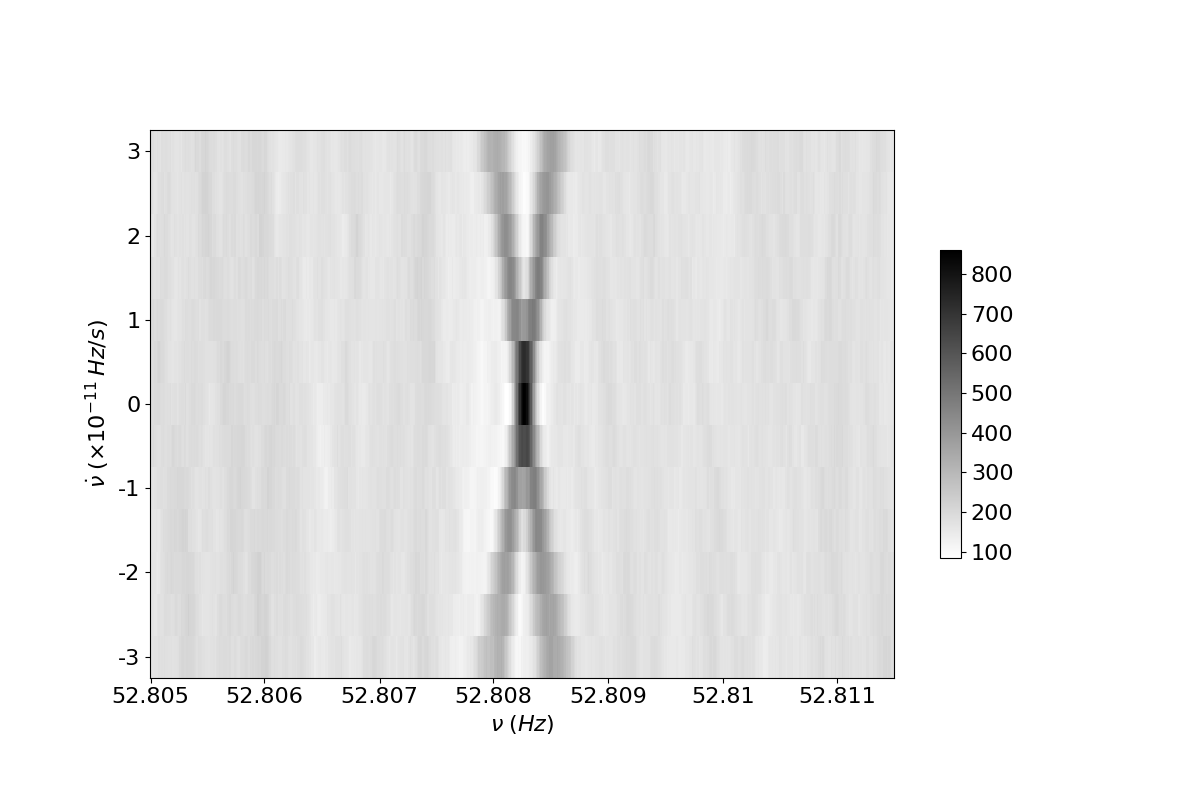

([<matplotlib.axis.YTick at 0x7f837eebae10>,
 <a list of 7 Text yticklabel objects>)

In [19]:
from matplotlib import pyplot
import numpy
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

percorsoIn = '/home/protoss/Documenti/TESI/wn100bkp/HOUGH052HWI.npy'
#percorsoIn = 'HOUGH052LLHWI.npy'

hough = numpy.load(percorsoIn)
pyplot.figure(figsize=(12, 8))

a = pyplot.imshow(hough[185:198,66800:67330], cmap = 'gray_r', origin = 'lower', interpolation = 'none', aspect = 30)
#a = pyplot.imshow(hough, cmap = 'gray_r', origin = 'lower', interpolation = 'none', aspect = 100)
pyplot.colorbar(shrink = 0.5,aspect = 15)

pyplot.xlabel('$\\nu \;(Hz)$',fontsize = 16)
pyplot.ylabel('$\dot{\\nu} \;(\\times 10^{-11}\: Hz/s)$', fontsize = 16)

pyplot.xticks(indXtick[:-1], valXtick[:-1])
pyplot.yticks(indYtick,valYtick)

#pyplot.savefig('puls5.png', format='png')

# Pulsar 108

In [49]:
 
import tensorflow as tf
import numpy
import scipy.io
import time
import glob


# PREPARO FUNZIONI

#TODO STUDIARE FATTIBILITÀ DI USARE TUTTO A 32BYTES

# calcola la correzione doppler per ogni punto del cielo
def doppcorr(i):
	quadratoNP = quadrato[i]
	indicesOpt = indices-1
	inizi = indicesOpt[:-1]
	fini = indicesOpt[1:]

	velocitas = numpy.zeros((3,frequenze.size))
	for i in numpy.arange(0,nTempi-1):
		velocitas[:,inizi[i]:fini[i]+1] = veloc[:,i:i+1]

	velPerPosIndex = numpy.dot(quadratoNP,velocitas)
	divisoreIndex = 1+velPerPosIndex
	freqCorr = frequenze / divisoreIndex
	##print(freqCorr)

	#mi ricavo l'header per le frequenze
	freqMin = numpy.amin(freqCorr)
	#freqMax = tf.reduce_max(freqCorr)
	freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato

	freqFinal = freqCorr-freqIniz
	freqFinal = (freqFinal/stepFreqRaffinato)-round(enhancement/2+0.001)

	#freqs = tf.concat([[freqIniz], freqCorr], 0)

	return freqIniz, freqCorr, freqFinal#, nstepFrequenze

def noncorr():
	freqMin = numpy.amin(frequenze)
	freqIniz = freqMin - stepFreq/2 -stepFreqRaffinato
	freqNonCor = (frequenze -freqIniz)/stepFreqRaffinato-round(enhancement/2+0.001)
	freqNonCor = tf.constant(freqNonCor, dtype = tf.float64)
	return freqNonCor


# calcola la hough per ogni punto del cielo (per ogni spindown)
def inDaHough(i, freqHM):
	def houghizza(stepIesimo):
		sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
		#sdTimed = tf.cast(sdTimed, dtype=tf.float32)

		appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
		appoggio = tf.cast(appoggio, dtype=tf.int32)

		#pesi32 = tf.cast(pesiHM, dtype = tf.float32)

		valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
		valorisx = tf.cast(valorisx, dtype=tf.float32)
		return valorisx

	houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

	def sliceInt():
		#faccio integrazione finale (vecchia versione senza conv)
		semiLarghezza = tf.round(enhancement/2+0.001)
		semiLarghezza = tf.cast(semiLarghezza, tf.int64)
		houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
		houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
		return houghInt

	hough = sliceInt()
	houghinal = tf.cumsum(hough, axis = 1)

	return houghinal


#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sessione = tf.Session(config=config)

#sessione = tf.Session()

# CARICO DATI

tFft = 8192
#tFft = 4096
tObs = 9 #mesi
tObs = tObs*30*24*60*60
cands = 100
primaFreq = 108


percorsoQuad = ("/home/protoss/Documenti/TESI/wn100bkp/quadHWI%d.mat" % primaFreq)
percorsoPatch = ("/home/protoss/Documenti/TESI/wn100bkp/quadHWI%dEcl.mat" % primaFreq)

#carico file per dopp corr
quadrato = scipy.io.loadmat(percorsoQuad)['quad'].astype(numpy.float64)
nPunti = quadrato.shape[0]
print(nPunti)
patch = scipy.io.loadmat(percorsoPatch)['quadratoEclNew'].astype(numpy.float64)

percorsoFile = ('/home/protoss/Documenti/TESI/wn100bkp/data/dati9mesi%dHWI.mat' % primaFreq)

#nPunti = 10
#nFiles = 2

allCands = numpy.zeros((1,nPunti,cands*2,9))


print(patch.shape, quadrato.shape)

struttura = scipy.io.loadmat(percorsoFile)['job_pack_0']
tempi = struttura['peaks'][0,0][0]#.astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1]#.astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1)#.astype(numpy.float32)

#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000
#securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement

#tempi
#epoca definita come mediana di tempi di tutto il run #WARNING da ridefinire con durata dati che prendo
epoca = (57722+57990)/2

#spindowns
spindownMin = -1e-9
spindownMax = 1e-10

#spindownMin = -2e-9
#spindownMax = 1e-9


stepSpindown = stepFreq/tObs

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int64)
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

#per doppler corr
veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float64)
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
indices = struttura['basic_info'][0,0]['index'][0,0][0]



#mettere un for
#start = time.time()
#for punto in numpy.arange(0,nPunti):

sessione = tf.Session()
freqInCorr,freqCorr, freqPerHough = doppcorr(0)


nstepsFreq = numpy.ceil(securbelt+(numpy.amax(freqCorr)-numpy.amin(freqCorr) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato)
##print(nstepsFreq)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

	#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi,dtype=tf.float64)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float64)

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float64)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int64)

#freqTF = noncorr()

freqTF = tf.constant(freqPerHough, dtype = tf.float64)
houghmap = inDaHough(0,freqTF)
hough = sessione.run(houghmap)


minDistance = enhancement*4
primaFreq = freqInCorr-(securbelt/2)*stepFreqRaffinato

freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]

#QUI ANALOGO FUNZIONE CUT GD2
#%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
#%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]

indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

imageCand = hough[:,indexIniziale:indexFinale].astype(numpy.int64)


#allCands[ifile,punto] = manchurian_candidates(cands, freqInCorr, hough, patch[punto])

#tf.reset_default_graph()
#sessione.close()

	#numCands = numpy.
#stop = time.time()


#numAllCands = numpy.int64(allCands.size/9)
#allCands = allCands.reshape(numAllCands,9)
#nonzeri = numpy.nonzero(allCands[:,0])
#finallCands = allCands[nonzeri]
#finallCands = numpy.transpose(finallCands)



#percorsoOut = ('candHWI%d.mat' % primaFreq)
#percorsoOut = 'provacand'



1
(1, 5) (1, 3)


In [50]:
t0 = 52944
epocaClean = (57722+57990)/2
deltaGiorni = epocaClean-t0
deltat = ((deltaGiorni)*24*3600)

f0 = 1.088571594000000e+02
df0 = -1.460000000000000e-17
freqvera = df0*deltat+f0
freqvera

108.85715939380381

In [51]:
import numpy
percorsoOut = '/home/protoss/Documenti/TESI/wn100bkp/HOUGH108HWI.npy'
#percorsoOut = 'HOUGH108LLHWI.npy'
numpy.save(percorsoOut, imageCand)


In [52]:
import numpy
spindownMin = -1e-9
spindownMax = 1e-10

primaRiga = 0
ultimaRiga = nstepSpindown

indYtick = numpy.float32([0,2,4,6,8,10,12])
rigaScelta = indYtick + 185.0
sdScelto = (spindownMax-spindownMin)/(ultimaRiga-primaRiga)*(rigaScelta-primaRiga)+spindownMin
print(sdScelto)

valYtick = sdScelto
valYtick = valYtick - numpy.amin(numpy.absolute(valYtick))
print(valYtick)
valYtick = [ -3,  -2,  -1,   0,
   1,   2,   3]
#binSDScelti = (ultimaRiga-primaRiga)/(spindownMax-spindownMin)*(sdScelti-spindownMin)+primaRiga


indtoSD = 1

freqMin = numpy.amin(freqCorr)
freqMax = numpy.amax(freqCorr)

primoIndice = 0
ultimoIndice = imageCand.shape[1]

colonScelet = numpy.float32([69950,70490])
#freqScelta = (freqMax-freqMin)/(ultimoIndice-primoIndice)*(colonScelta-primoIndice)+freqMin
#print(freqScelta)
valXtick = [108.854, 108.855,108.856, 108.857,108.858,108.859,108.860]



freqScelta = valXtick
binFreqScelta  = (ultimoIndice-primoIndice)/(freqMax-freqMin)*(freqScelta-freqMin)+primoIndice

indXtick = numpy.round(binFreqScelta)
indXtick = indXtick-indXtick[0]+30

[-3.0952352e-11 -2.0476176e-11 -1.0000001e-11  4.7617466e-13
  1.0952350e-11  2.1428526e-11  3.1904812e-11]
[-3.14285264e-11 -2.09523510e-11 -1.04761755e-11  0.00000000e+00
  1.04761755e-11  2.09523510e-11  3.14286375e-11]


<IPython.core.display.Javascript object>


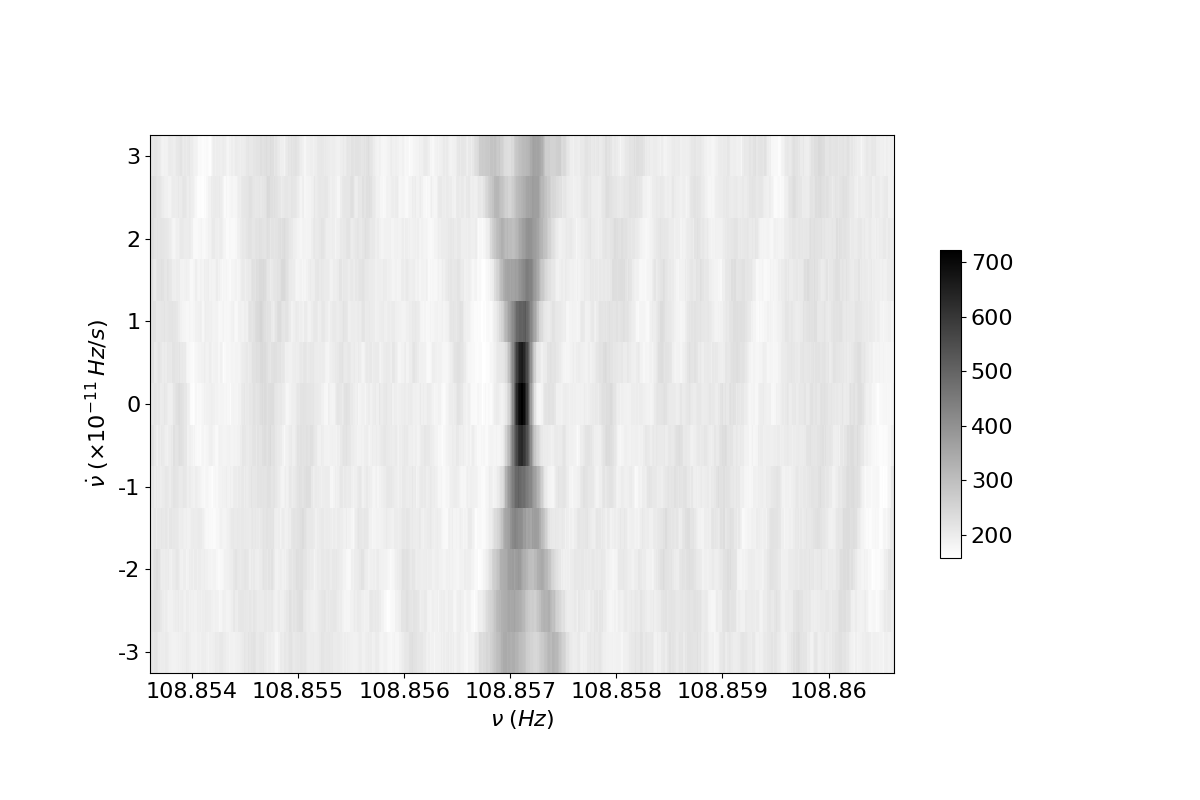

In [53]:
from matplotlib import pyplot
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

percorsoIn = '/home/protoss/Documenti/TESI/wn100bkp/HOUGH108HWI.npy'
#percorsoIn = 'HOUGH108LLHWI.npy'
hough = numpy.load(percorsoIn)
pyplot.figure(figsize=(12, 8))

a = pyplot.imshow(hough[185:198,69950:70490], cmap = 'gray_r', origin = 'lower', interpolation = 'none', aspect = 30)
pyplot.colorbar(shrink = 0.5,aspect = 15)
pyplot.show()
pyplot.xlabel('$\\nu \;(Hz)$', fontsize = 16)
pyplot.ylabel('$\dot{\\nu} \;(\\times 10^{-11}\:Hz/s)$', fontsize = 16)

pyplot.xticks(indXtick[:], valXtick)
pyplot.yticks(indYtick,valYtick)

pyplot.savefig('puls3.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

# 187

In [1]:
 
import tensorflow as tf
import numpy
import scipy.io
import time
import glob


# PREPARO FUNZIONI

#TODO STUDIARE FATTIBILITÀ DI USARE TUTTO A 32BYTES

# calcola la correzione doppler per ogni punto del cielo
def doppcorr(i):
	quadratoNP = quadrato[i]
	indicesOpt = indices-1
	inizi = indicesOpt[:-1]
	fini = indicesOpt[1:]

	velocitas = numpy.zeros((3,frequenze.size))
	for i in numpy.arange(0,nTempi-1):
		velocitas[:,inizi[i]:fini[i]+1] = veloc[:,i:i+1]

	velPerPosIndex = numpy.dot(quadratoNP,velocitas)
	divisoreIndex = 1+velPerPosIndex
	freqCorr = frequenze / divisoreIndex
	##print(freqCorr)

	#mi ricavo l'header per le frequenze
	freqMin = numpy.amin(freqCorr)
	#freqMax = tf.reduce_max(freqCorr)
	freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato

	freqFinal = freqCorr-freqIniz
	freqFinal = (freqFinal/stepFreqRaffinato)-round(enhancement/2+0.001)

	#freqs = tf.concat([[freqIniz], freqCorr], 0)

	return freqIniz, freqCorr, freqFinal#, nstepFrequenze

def noncorr():
	freqMin = numpy.amin(frequenze)
	freqIniz = freqMin - stepFreq/2 -stepFreqRaffinato
	freqNonCor = (frequenze -freqIniz)/stepFreqRaffinato-round(enhancement/2+0.001)
	freqNonCor = tf.constant(freqNonCor, dtype = tf.float64)
	return freqNonCor


# calcola la hough per ogni punto del cielo (per ogni spindown)
def inDaHough(i, freqHM):
	def houghizza(stepIesimo):
		sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
		#sdTimed = tf.cast(sdTimed, dtype=tf.float32)

		appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
		appoggio = tf.cast(appoggio, dtype=tf.int32)

		#pesi32 = tf.cast(pesiHM, dtype = tf.float32)

		valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
		valorisx = tf.cast(valorisx, dtype=tf.float32)
		return valorisx

	houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

	def sliceInt():
		#faccio integrazione finale (vecchia versione senza conv)
		semiLarghezza = tf.round(enhancement/2+0.001)
		semiLarghezza = tf.cast(semiLarghezza, tf.int64)
		houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
		houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
		return houghInt

	hough = sliceInt()
	houghinal = tf.cumsum(hough, axis = 1)

	return houghinal


#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sessione = tf.Session(config=config)

#sessione = tf.Session()

# CARICO DATI

#tFft = 8192
tFft = 4096
tObs = 9 #mesi
tObs = tObs*30*24*60*60
cands = 100
primaFreq = 187


percorsoQuad = ("/home/protoss/Documenti/TESI/wn100bkp/quadHWI%d.mat" % primaFreq)
percorsoPatch = ("/home/protoss/Documenti/TESI/wn100bkp/quadHWI%dEcl.mat" % primaFreq)

#carico file per dopp corr
quadrato = scipy.io.loadmat(percorsoQuad)['quad'].astype(numpy.float64)
nPunti = quadrato.shape[0]
print(nPunti)
patch = scipy.io.loadmat(percorsoPatch)['quadratoEclNew'].astype(numpy.float64)

percorsoFile = ('/home/protoss/Documenti/TESI/wn100bkp/data/dati9mesi%dHWI.mat' % primaFreq)

#nPunti = 10
#nFiles = 2

allCands = numpy.zeros((1,nPunti,cands*2,9))


print(patch.shape, quadrato.shape)

struttura = scipy.io.loadmat(percorsoFile)['job_pack_0']
tempi = struttura['peaks'][0,0][0]#.astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1]#.astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1)#.astype(numpy.float32)

#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
#securbelt = 4000
securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement

#tempi
#epoca definita come mediana di tempi di tutto il run #WARNING da ridefinire con durata dati che prendo
epoca = (57722+57990)/2

#spindowns
#spindownMin = -1e-9
#spindownMax = 1e-10

spindownMin = -10e-9
spindownMax = -7e-9


stepSpindown = stepFreq/tObs

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int64)
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

#per doppler corr
veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float64)
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
indices = struttura['basic_info'][0,0]['index'][0,0][0]



#mettere un for
#start = time.time()
#for punto in numpy.arange(0,nPunti):

sessione = tf.Session()
freqInCorr,freqCorr, freqPerHough = doppcorr(0)


nstepsFreq = numpy.ceil(securbelt+(numpy.amax(freqCorr)-numpy.amin(freqCorr) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato)
##print(nstepsFreq)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

	#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi,dtype=tf.float64)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float64)

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float64)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int64)

#freqTF = noncorr()

freqTF = tf.constant(freqPerHough, dtype = tf.float64)
houghmap = inDaHough(0,freqTF)
hough = sessione.run(houghmap)


minDistance = enhancement*4
primaFreq = freqInCorr-(securbelt/2)*stepFreqRaffinato

freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]

#QUI ANALOGO FUNZIONE CUT GD2
#%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
#%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]

indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

imageCand = hough[:,indexIniziale:indexFinale].astype(numpy.int64)


#allCands[ifile,punto] = manchurian_candidates(cands, freqInCorr, hough, patch[punto])

#tf.reset_default_graph()
#sessione.close()

	#numCands = numpy.
#stop = time.time()


#numAllCands = numpy.int64(allCands.size/9)
#allCands = allCands.reshape(numAllCands,9)
#nonzeri = numpy.nonzero(allCands[:,0])
#finallCands = allCands[nonzeri]
#finallCands = numpy.transpose(finallCands)



#percorsoOut = ('candHWI%d.mat' % primaFreq)
#percorsoOut = 'provacand'



1
(1, 5) (1, 3)


In [3]:
t0 = 52944
epocaClean = (57722+57990)/2
deltaGiorni = epocaClean-t0
deltat = ((deltaGiorni)*24*3600)

f0 = 1.943083185000000e+02
df0 = -8.650000000000000e-09
freqvera = df0*deltat+f0
freqvera


190.63728618000002

In [4]:
import numpy
percorsoOut = '/home/protoss/Documenti/TESI/wn100bkp/HOUGH0187HWI.npy'
numpy.save(percorsoOut, imageCand)


In [9]:
import numpy


primaRiga = 0
ultimaRiga = nstepSpindown


rigaScelta = numpy.float64([123,125,127,129,131,133,135])
sdScelto = (spindownMax-spindownMin)/(ultimaRiga-primaRiga)*(rigaScelta-primaRiga)+spindownMin
print(sdScelto)

valYtick = sdScelto-sdScelto[3]-8.650000000000000e-09

indYtick = rigaScelta-123
valYtick = [ -8.71 , -8.69 , -8.67 , -8.65 , -8.63, -8.61 , -8.59]
#binSDScelti = (ultimaRiga-primaRiga)/(spindownMax-spindownMin)*(sdScelti-spindownMin)+primaRiga



freqMin = numpy.amin(freqCorr)
freqMax = numpy.amax(freqCorr)

primoIndice = 0
ultimoIndice = imageCand.shape[1]

colonScelta = numpy.float32([148700,148800,148900,149000,149100,149200])
freqScelta = (freqMax-freqMin)/(ultimoIndice-primoIndice)*(colonScelta-primoIndice)+freqMin
print(freqScelta)
valXtick = [ '.635' , '.636' , '.637',  '.638' , '.639', '.640']



#freqScelta = valXtick
binFreqScelta  = (ultimoIndice-primoIndice)/(freqMax-freqMin)*(freqScelta-freqMin)+primoIndice
print(binFreqScelta)
indXtick = numpy.round(binFreqScelta)
indXtick = indXtick-indXtick[0]+50

[-8.71428571e-09 -8.69337979e-09 -8.67247387e-09 -8.65156794e-09
 -8.63066202e-09 -8.60975610e-09 -8.58885017e-09]
[190.65611 190.6586  190.6611  190.66359 190.66609 190.66858]
[148700.08 148799.77 148900.08 148999.78 149100.1  149199.8 ]


<IPython.core.display.Javascript object>


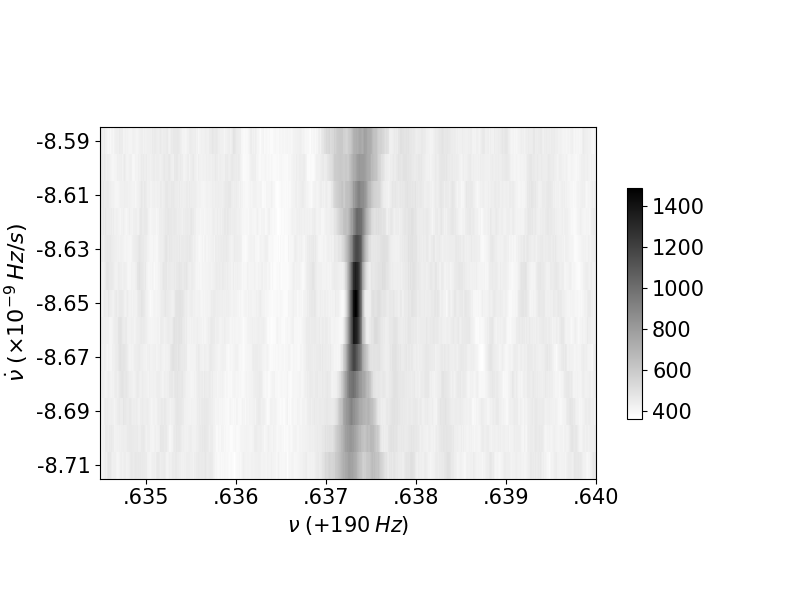

In [11]:
from matplotlib import pyplot
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['font.size'] = 15
#percorsoIn = 'HOUGH108HWI.npy'
#percorsoIn = 'HOUGH108LLHWI.npy'
#hough = numpy.load(percorsoIn)
pyplot.figure(figsize=(8, 6))

a = pyplot.imshow(imageCand[123:136,148700:149250], cmap = 'gray_r', origin = 'lower', interpolation = 'none', aspect = 30)
pyplot.colorbar(shrink = 0.5,aspect = 15)
pyplot.show()
pyplot.xlabel('$\\nu  \;(+190\: Hz)$', fontsize = 15)
pyplot.ylabel('$\dot{\\nu} \;(\\times 10^{-9}\:Hz/s)$',fontsize = 16)

pyplot.xticks(indXtick, valXtick)
pyplot.yticks(indYtick,valYtick)

pyplot.savefig('puls8.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)